## inspect the data and generate the fearure map

### load the raw image

In [1]:
# import the necessary packages
import imutils
import matplotlib.pyplot as plt

import os
import numpy as np
from scipy import ndimage
from tqdm import tqdm  # ! this might result into problem with 'object'
import pandas as pd
import random
import glob
from skimage import io

import argparse
import time
import cv2

In [2]:
# visualize the images

import matplotlib.pyplot as plt

def visualizeIMG(n_slice, stack):
    print('n_slice:', n_slice)
    temp = stack[n_slice,...]
    plt.imshow(temp, cmap='gray')
    
def subShow(IMG1, IMG2):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(IMG1, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(IMG2, cmap='gray')
    plt.show()

In [3]:
# load the tif stack

def readTIF(data_path):
    images = []
    for img in glob.glob(os.path.join(data_path, "*.tif")):
        
        im = io.imread(os.path.join(data_path, img))  
        imarray = np.array(im)
        images.append(imarray)  # images, num of slices, channels, img.x, img.y
    return np.asarray(images)

#### load data

In [4]:
DATA_PATH = 'E:/LM/LM/digitalConfocal/data/interim/zebra_fish/'

rawData = readTIF(DATA_PATH)  # multiple stacks, each contains two channels, each channel 20 imgs. [NStack, N, CH, H, W]
rawGray = rawData[:,:,1,...]  # gray channel
print('raw size:', rawGray.shape)

raw size: (1, 20, 1040, 1392)


n_slice: 18


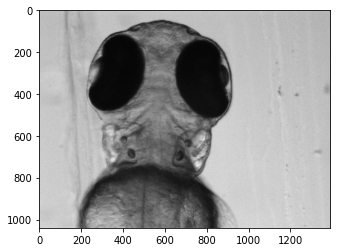

In [5]:
# visualize the image

import random

n_slice = random.randint(0, rawGray.shape[1]-1)

visualizeIMG(n_slice, rawGray[0,...])

#### check the range of the data, rescale

In [6]:
# check the range of the data

n_stack = 0
stackTemp = rawGray[n_stack,...]

print('raw range before:', stackTemp.min(), stackTemp.max(), stackTemp.shape)

if stackTemp.max() == 255:
    print('scale is good')
else:
    print('plz resacle the data')

raw range before: 0 95 (20, 1040, 1392)
plz resacle the data


In [7]:
# rescale by stack
rescaleGray = rawGray

for stack in range(rescaleGray.shape[0]):
    rescaleGray[stack,...] = np.interp(rescaleGray[stack,...], (rescaleGray[stack,...].min(), rescaleGray[stack,...].max()), (0, 255))

print(rescaleGray.shape)
print('after rescale:', rescaleGray[0,...].min(), rescaleGray[0,...].max())

(1, 20, 1040, 1392)
after rescale: 0 255


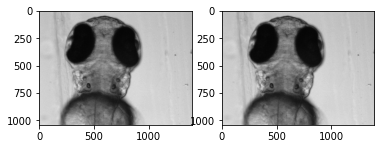

In [8]:
# visualize some images

tempIMG = 10

subShow(rawGray[0, tempIMG,:,:], rescaleGray[0, tempIMG,:,:])

#### crop image into correct size. crop out the useless part

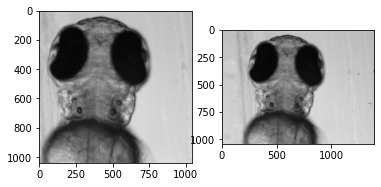

after crop: (1, 20, 1040, 1040)


In [9]:
# crop into square

rescaleGrayCrop = rescaleGray[...,176:(176+rescaleGray.shape[2])]  # crop into square
subShow(rescaleGrayCrop[0, tempIMG,:,:], rescaleGray[0, tempIMG,:,:])

rescaleGray = rescaleGrayCrop
print('after crop:', rescaleGray.shape)

### generate the feauture map manually. calculate the std

#### padd to avoid the artifacts

In [3]:
# define the parameters

# step size
stepArray = [8, 10]
# stepArray = [8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36]

# window size
(winW, winH) = (64*2, 64*2)
# (winW, winH) = (512, 512)
# (padW, padH) = (256, 256)

# pad parameters
(padW, padH) = (0, winH)
# (padW, padH) = (0, winH)

# saved path
# savedPath = 'H:/My Drive/rawData/HZDR/LM/fMax_zebrafish/testPadMax'  # google drive
savedPath = 'E:/LM/LM/digitalConfocal/notebooks/fMax/testResult/padMax'

In [11]:
# padding by stacks

stackPad = []

for stack in range(rescaleGray.shape[0]):
    tempStack = rescaleGray[stack,...]
    print('before:', tempStack.max())
    tempMean = np.round(np.mean(tempStack)).astype('int')  # mean of whole stack
    print(stack, tempMean)
    tempStack = np.pad(tempStack, ((0,0), (padH,0), (padW,0)), 'constant', constant_values=tempMean) 
    print('after:', tempStack.max())
    stackPad.append(tempStack)
    
stackPad = np.asarray(stackPad)
print('after pad:', stackPad.shape, stackPad.max())

before: 255
0 121
after: 255
after pad: (1, 20, 1168, 1040) 255


pad slice: 18


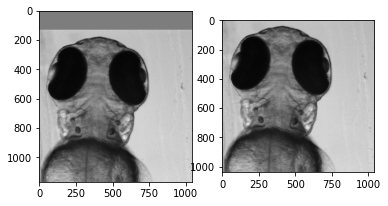

In [12]:
# visualize

n_stack = 0
# n_slice = random.randint(0, stackPad.shape[1]-1)
n_slice = 18
# visualizeIMG(n_slice, stackPad[n_stack,...])

print('pad slice:', n_slice)
subShow(stackPad[n_stack,n_slice,:,:], rescaleGray[n_stack,n_slice,:,:])


#### max projection in every slice in the stack of std dev

In [15]:
# create the folder to save the stacks

import os

def mkdir(path):
    folder = os.path.exists(path)
    if not folder:                   
        os.makedirs(path)           
    # else:
    #     print('path existed')


In [16]:
# multiple scans for one image.
# input: stack num, slice num, image, step, windowsize

def slidingStackStd(stackNum, sliceNum, image, stepArray, windowSize, savedPath):
    
    focalStack = []
    
    for i in range(len(stepArray)):
        
        stepSize = stepArray[i]
        # slide a window across the image
        stdMap = np.zeros((image.shape[:2]))  # careful the image is 3 channels

        for y in range(0, image.shape[0], stepSize):
            for x in range(0, image.shape[1], stepSize):
                # yield the current window
                yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
                
                tPatch = image[y:y + windowSize[1], x:x + windowSize[0], 0]  # taking only 1 channel from 3
                
                # Roy. calculate the std
                tempStdPatch = np.ones((tPatch.shape)) * np.std((tPatch))  
                
                # print(tempStdPatch)
                stdMap[y:y + windowSize[1], x:x + windowSize[0]] = tempStdPatch + stdMap[y:y + windowSize[1], x:x + windowSize[0]]
                
                # print(tempStd)
                
#         focalStack.append(stdMap)
        focalStack.append(stdMap[padH:, padW:])  # crop the feature map back 
        
    # calculate the stack and conduct max projection
    fMax = np.max(np.asarray(focalStack), axis=0)
    
    # rescale the stacks back to [0, 255]
    fMax = np.interp(fMax, (fMax.min(), fMax.max()), (0, 255))
    
    # check the saving path
    tempPath = savedPath + '/' + str(stackNum)
    mkdir(tempPath)
    
    # save the max projection in sliceNum under the path 'stackNum'
    np.save(tempPath+'/'+str(sliceNum)+'.npy', fMax)

In [15]:
#  visualize the scanning process of one image

def visualizeStack(stackNum, sliceNum, image, stepArray, windowSize, savedPath):
    
    # slide window scanning for one test
    # 可以改变window size进行多层次的扫描
    
    for (x, y, window) in slidingStack(stackNum, sliceNum, image, stepArray=stepArray, windowSize=(winW, winH), savedPath=savedPath):
        # if the window does not meet our desired window size, ignore it
        if window.shape[0] != winH or window.shape[1] != winW:
            continue
        # draw the window during the process
        clone = image.copy() 
        cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)  # third param indicates the colour
        cv2.imshow("Window", clone)
        cv2.waitKey(1)
           # time.sleep(0.025)
        time.sleep(0.00025)
    cv2.destroyAllWindows() 

In [ ]:
# target stack

# targetStack = stackPad

# scan the images in step size
for stackNum in range(targetStack.shape[0]):
    
    for sliceNum in range(targetStack.shape[1]):
        image = np.stack((targetStack[stackNum,sliceNum,...],)*3, axis=-1) 
        for (x, y, window) in slidingStackStd(stackNum, sliceNum, image, stepArray=stepArray, windowSize=(winW, winH), savedPath=savedPath):
        # if the window does not meet our desired window size, ignore it
            if window.shape[0] != winH or window.shape[1] != winW:
                continue 
                
print(targetStack.shape)

#### load the cal results

In [13]:
# define the read in function for max projection

def readNpy(data_path):
    fStack = []
    for img in glob.glob(os.path.join(data_path, "*.npy")):
        im = np.load(os.path.join(data_path, img))  
        imarray = np.array(im)
        fStack.append(imarray)  # images, num of slices, channels, img.x, img.y
    return np.asarray(fStack)

In [14]:
print(stackPad.shape)

(1, 20, 1168, 1392)


In [15]:
# visualize the one of the stacks

targetStack = stackPad

# read in multiple stacks
fStacks = []
print('max project size:', targetStack.shape)

for i in range(targetStack.shape[0]):
    fStackTemp = readNpy(savedPath + '/' + str(i) + '/')
    fStacks.append(fStackTemp)
    
fStacks = np.asarray(fStacks)
print('fStacks shape:', fStacks.shape, fStacks.min(), fStacks.max())

max project size: (1, 20, 1168, 1392)


ValueError: zero-size array to reduction operation minimum which has no identity

slice num: 12


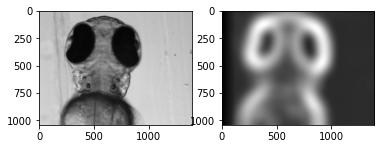

In [21]:
# visualize

n_stack = 0
n_slice = random.randint(0, fStacks.shape[1]-1)
# n_slice = 0

print('slice num:', n_slice)
subShow(rawGray[n_stack,n_slice,:,:], fStacks[n_stack,n_slice,:,:])

### calculate in conv. // not possible, since conv is not linear operations

### experiments the different contour metrics

#### take a patch

windows size: 128
patch max: 174


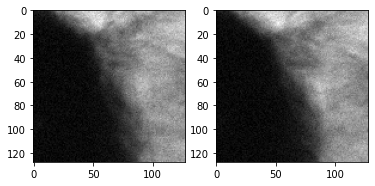

In [63]:
# fetch the patch
# take a patch from two neighbour images

n_stack = 0
# n_slice = random.randint(0, stackPad.shape[1]-1)
n_slice = 10
windowSize = [winW, winH]
print('windows size:', winW)

tempIMG1 = stackPad[n_stack, n_slice, :, :]
tempIMG2 = stackPad[n_stack, n_slice+2, :, :]

# startPoint1 = [0, 0]
# startPoint2 = [250, 250]

startPoint1 = [250, 250]
startPoint2 = startPoint1

# two patches for comparing
tempPatch1 = tempIMG1[startPoint1[0]:startPoint1[0] + windowSize[1], startPoint1[1]:startPoint1[1] + windowSize[0]]
tempPatch2 = tempIMG2[startPoint2[0]:startPoint2[0] + windowSize[1], startPoint2[1]:startPoint2[1] + windowSize[0]]

print('patch max:', tempPatch1.max())

subShow(tempPatch1, tempPatch2)

#### use the contour detector to evaluate the patch quality

In [46]:
# test various metrics

import cv2

# calculate the entropy
from skimage.filters.rank import entropy
from skimage.morphology import disk

# robert
def robertCal(tempPatch):
    # define the kernel
    roberts_cross_v = np.array( [[1, 0 ],[0,-1 ]] )

    roberts_cross_h = np.array( [[ 0, 1 ],[ -1, 0 ]] )

    img = tempPatch.astype('float64')
    img/=255.0

    vertical = ndimage.convolve( img, roberts_cross_v )
    horizontal = ndimage.convolve( img, roberts_cross_h )

    edged_img = np.sqrt( np.square(horizontal) + np.square(vertical))
    edged_img*=255
    
    return edged_img

# rescale the image for comparing
def rescaleIMG(img, MIN, MAX):
    temp = np.interp(img, (img.min(), img.max()), (MIN, MAX))
    return temp

def calEntropy(img, diskNum):
    
    entropy_mat = entropy(img, disk(diskNum))  # Range is about [0, 6]
    # convert back to uint8
    entropy_frame = (entropy_mat * 255/np.max(entropy_mat)).astype(np.uint8)
    
    # print(entropy_frame.max(), entropy_frame.min(), entropy_frame.mean())
    return entropy_frame
    

In [47]:
# loG

import numpy as np
import scipy.misc
import cv2   


def laplace_of_gaussian(gray_img, sigma=1., kappa=0.75, pad=False):
    """
    Applies Laplacian of Gaussians to grayscale image.

    :param gray_img: image to apply LoG to
    :param sigma:    Gauss sigma of Gaussian applied to image, <= 0. for none
    :param kappa:    difference threshold as factor to mean of image values, <= 0 for none
    :param pad:      flag to pad output w/ zero border, keeping input image size
    """
    assert len(gray_img.shape) == 2
    img = cv2.GaussianBlur(gray_img, (0, 0), sigma) if 0. < sigma else gray_img
    img = cv2.Laplacian(img, cv2.CV_64F)
    rows, cols = img.shape[:2]
    # min/max of 3x3-neighbourhoods
    min_map = np.minimum.reduce(list(img[r:rows-2+r, c:cols-2+c]
                                     for r in range(3) for c in range(3)))
    max_map = np.maximum.reduce(list(img[r:rows-2+r, c:cols-2+c]
                                     for r in range(3) for c in range(3)))
    # bool matrix for image value positiv (w/out border pixels)
    pos_img = 0 < img[1:rows-1, 1:cols-1]
    # bool matrix for min < 0 and 0 < image pixel
    neg_min = min_map < 0
    neg_min[1 - pos_img] = 0
    # bool matrix for 0 < max and image pixel < 0
    pos_max = 0 < max_map
    pos_max[pos_img] = 0
    # sign change at pixel?
    zero_cross = neg_min + pos_max
    # values: max - min, scaled to 0--255; set to 0 for no sign change
    value_scale = 255. / max(1., img.max() - img.min())
    values = value_scale * (max_map - min_map)
    values[1 - zero_cross] = 0.
    # optional thresholding
    if 0. <= kappa:
        thresh = float(np.absolute(img).mean()) * kappa
        values[values < thresh] = 0.
    log_img = values.astype(np.uint8)
    if pad:
        log_img = np.pad(log_img, pad_width=1, mode='constant', constant_values=0)
    return log_img

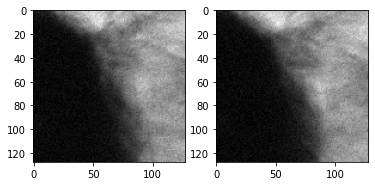

differ in original: 0.017313565276926953


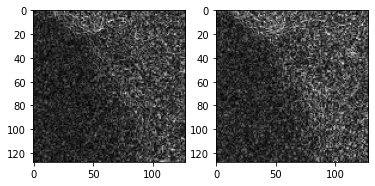

differ in robert: 0.06178868097384951


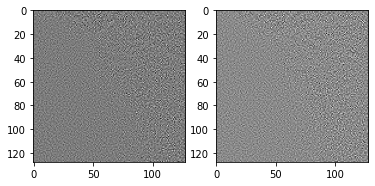

differ in laplacian: 0.05336111907539506


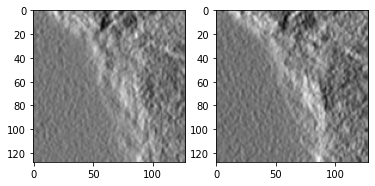

differ in sobel: 0.034376010599210624


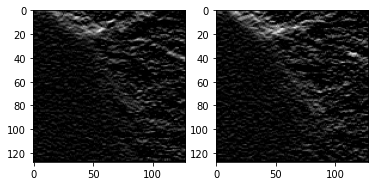

differ in prewitt: 0.09066911251014852


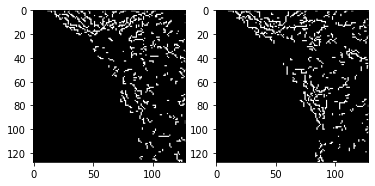

differ in canny: 0.0230505149583129


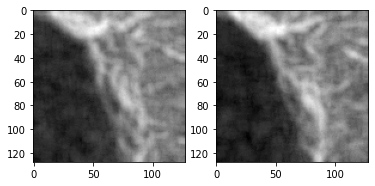

differ in entropy: 0.0035864784195158875


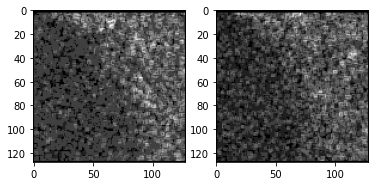

differ in loG: 0.05456073249884098


In [64]:
# original 
tempPatchScale1 = rescaleIMG(tempPatch1, 0, 1); tempPatchScale2 = rescaleIMG(tempPatch2, 0, 1)
subShow(tempPatchScale1, tempPatchScale2)

distO = np.abs(tempPatchScale1.mean()- tempPatchScale2.mean())
print('differ in original:', distO/(tempPatchScale1.mean()+tempPatchScale2.mean()))

# robert 
robert1 = robertCal(tempPatch1); robert1 = rescaleIMG(robert1, 0, 1)
robert2 = robertCal(tempPatch2); robert2 = rescaleIMG(robert2, 0, 1)
subShow(robert1, robert2)

distR = np.abs(robert1.mean()- robert2.mean())
print('differ in robert:', distR/(robert1.mean()+robert2.mean()))

# laplacian
laplacian1 = cv2.Laplacian(tempPatch1,cv2.CV_64F);laplacian1 = rescaleIMG(laplacian1, 0, 1)
laplacian2 = cv2.Laplacian(tempPatch2,cv2.CV_64F); laplacian2 = rescaleIMG(laplacian2, 0, 1)

distL = np.abs(laplacian1.mean()-laplacian2.mean())
subShow(laplacian1, laplacian2)
print('differ in laplacian:', distL/(laplacian1.mean()+laplacian2.mean()))

# sobel
sobelx1 = cv2.Sobel(tempPatch1,cv2.CV_64F,1,0,ksize=5); sobelx1 = rescaleIMG(sobelx1, 0, 1)
sobely1 = cv2.Sobel(tempPatch1,cv2.CV_64F,0,1,ksize=5); sobely1 = rescaleIMG(sobely1, 0, 1)

sobelx2 = cv2.Sobel(tempPatch2,cv2.CV_64F,1,0,ksize=5); sobelx2 = rescaleIMG(sobelx2, 0, 1)
sobely2 = cv2.Sobel(tempPatch2,cv2.CV_64F,0,1,ksize=5); sobely2 = rescaleIMG(sobely2, 0, 1)

distS =  np.abs(sobelx1.mean() + sobely1.mean()- (sobelx2.mean() + sobely2.mean()))
subShow(sobelx1, sobelx2)
print('differ in sobel:',distS/ (sobelx1.mean() + sobely1.mean() + sobelx2.mean() + sobely2.mean()))

# prewitt
kernelx = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
kernely = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])

img_prewittx1 = cv2.filter2D(tempPatch1, -1, kernelx); img_prewittx1 = rescaleIMG(img_prewittx1, 0, 1)
img_prewitty1 = cv2.filter2D(tempPatch1, -1, kernely); img_prewitty1 = rescaleIMG(img_prewitty1, 0, 1)

img_prewittx2 = cv2.filter2D(tempPatch2, -2, kernelx); img_prewittx2 = rescaleIMG(img_prewittx2, 0, 1)
img_prewitty2 = cv2.filter2D(tempPatch2, -2, kernely); img_prewitty2 = rescaleIMG(img_prewitty2, 0, 1)

distP = np.abs(img_prewittx1.mean() + img_prewitty1.mean()- (img_prewittx2.mean() + img_prewitty2.mean()))
subShow(img_prewittx1, img_prewittx2)
print('differ in prewitt:', distP/(img_prewittx1.mean() + img_prewitty1.mean() + img_prewittx2.mean() + img_prewitty2.mean()) )

# canny
img_canny1 = cv2.Canny(tempPatch1,75,100); img_canny1 = rescaleIMG(img_canny1, 0, 1)
img_canny2 = cv2.Canny(tempPatch2,75,100); img_canny2 = rescaleIMG(img_canny2, 0, 1)

distC = np.abs(img_canny1.mean()- img_canny2.mean())
subShow(img_canny1, img_canny2)
print('differ in canny:', distC/ (img_canny1.mean()+img_canny2.mean()))

# entropy
diskNum  = 5
entropy1 = calEntropy(tempPatch1, diskNum); entropy1 = rescaleIMG(entropy1, 0, 1)
entropy2 = calEntropy(tempPatch2, diskNum); entropy2 = rescaleIMG(entropy2, 0, 1)

distE = np.abs(entropy1.mean()- entropy2.mean())
subShow(entropy1, entropy2)
print('differ in entropy:', distC/ (entropy1.mean()+ entropy2.mean()))


# loG
loG1 = laplace_of_gaussian(tempPatch1); loG1 = rescaleIMG(loG1, 0, 1)
loG2 = laplace_of_gaussian(tempPatch2); loG2 = rescaleIMG(loG2, 0, 1)

distLoG = np.abs(loG1.mean()- loG2.mean())
subShow(loG1, loG2)
print('differ in loG:', distLoG/ (loG1.mean()+ loG2.mean()))

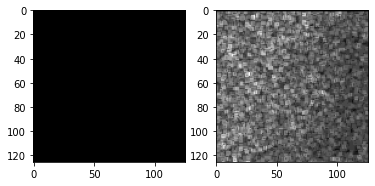

differ in loG: 1.0
(126, 126) 0 216


In [25]:
# 为什么loG会是空的

loG1 = laplace_of_gaussian(tempPatch1); #loG1 = rescaleIMG(loG1, 0, 1)
loG2 = laplace_of_gaussian(tempPatch2); #loG2 = rescaleIMG(loG2, 0, 1)

distLoG = np.abs(loG1.mean()- loG2.mean())
subShow(loG1, loG2)

print('differ in loG:', distLoG/ (loG1.mean()+ loG2.mean()))
print(loG1.shape, loG2.min(), loG2.max())
# print(loG2)

### calculate different contour metrics in one stack

In [49]:
# create the folder to save the stacks

import os

def mkdir(path):
    folder = os.path.exists(path)
    if not folder:                   
        os.makedirs(path)           
    # else:
    #     print('path existed')

In [50]:
import cv2

# calculate the entropy
from skimage.filters.rank import entropy
from skimage.morphology import disk

import numpy as np
import scipy.misc
import cv2  

# robert
def robertCal(tempPatch):
    # define the kernel
    roberts_cross_v = np.array( [[1, 0 ],[0,-1 ]] )

    roberts_cross_h = np.array( [[ 0, 1 ],[ -1, 0 ]] )

    img = tempPatch.astype('float64')
    img/=255.0

    vertical = ndimage.convolve( img, roberts_cross_v )
    horizontal = ndimage.convolve( img, roberts_cross_h )

    edged_img = np.sqrt( np.square(horizontal) + np.square(vertical))
    edged_img*=255
    
    return edged_img

# rescale the image for comparing
def rescaleIMG(img, MIN, MAX):
    temp = np.interp(img, (img.min(), img.max()), (MIN, MAX))
    return temp

def calEntropy(img, diskNum):
    
    entropy_mat = entropy(img, disk(diskNum))  # Range is about [0, 6]
    # convert back to uint8
    entropy_frame = (entropy_mat * 255/np.max(entropy_mat)).astype(np.uint8)
    
    # print(entropy_frame.max(), entropy_frame.min(), entropy_frame.mean())
    return entropy_frame

def calSobel(img):
    
    sobelx1 = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
    sobely1 = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
    
    return (sobelx1 + sobely1)  # return the sum

def calPrewitt(img):
    
    kernelx = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
    kernely = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])

    img_prewittx1 = cv2.filter2D(img, -1, kernelx)
    img_prewitty1 = cv2.filter2D(img, -1, kernely)
    
    return (img_prewittx1 + img_prewitty1)

# loG
def laplace_of_gaussian(gray_img, sigma=1., kappa=0.75, pad=True):
    """
    Applies Laplacian of Gaussians to grayscale image.

    :param gray_img: image to apply LoG to
    :param sigma:    Gauss sigma of Gaussian applied to image, <= 0. for none
    :param kappa:    difference threshold as factor to mean of image values, <= 0 for none
    :param pad:      flag to pad output w/ zero border, keeping input image size
    """
    assert len(gray_img.shape) == 2
    img = cv2.GaussianBlur(gray_img, (0, 0), sigma) if 0. < sigma else gray_img
    img = cv2.Laplacian(img, cv2.CV_64F)
    rows, cols = img.shape[:2]
    # min/max of 3x3-neighbourhoods
    min_map = np.minimum.reduce(list(img[r:rows-2+r, c:cols-2+c]
                                     for r in range(3) for c in range(3)))
    max_map = np.maximum.reduce(list(img[r:rows-2+r, c:cols-2+c]
                                     for r in range(3) for c in range(3)))
    # bool matrix for image value positiv (w/out border pixels)
    pos_img = 0 < img[1:rows-1, 1:cols-1]
    # bool matrix for min < 0 and 0 < image pixel
    neg_min = min_map < 0
    neg_min[1 - pos_img] = 0
    # bool matrix for 0 < max and image pixel < 0
    pos_max = 0 < max_map
    pos_max[pos_img] = 0
    # sign change at pixel?
    zero_cross = neg_min + pos_max
    # values: max - min, scaled to 0--255; set to 0 for no sign change
    # value_scale = 255. / max(1., img.max() - img.min())  # scale to 10-0 to avoid nan
    value_scale = 10. / max(1., img.max() - img.min())
    values = value_scale * (max_map - min_map)
    values[1 - zero_cross] = 0.
    # optional thresholding
    if 0. <= kappa:
        thresh = float(np.absolute(img).mean()) * kappa
        values[values < thresh] = 0.
    log_img = values.astype(np.uint8)
    if pad:
        log_img = np.pad(log_img, pad_width=1, mode='constant', constant_values=0)
    return log_img



In [51]:
# multiple scans for one image.
# input: stack num, slice num, image, step, windowsize, metric: indicate the metric for detecting

def slidingStackMetrics(stackNum, sliceNum, image, stepArray, windowSize, savedPath, metric):
    
    focalStack = []
    
    for i in range(len(stepArray)):
        
        stepSize = stepArray[i]
        # slide a window across the image
        feaMap = np.zeros((image.shape[:2]))  # careful the image is 3 channels

        for y in range(0, image.shape[0], stepSize):
            for x in range(0, image.shape[1], stepSize):
                # yield the current window
                yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
                
                # tPatch = image[y:y + windowSize[1], x:x + windowSize[0], 0]  # taking only 1 channel from 3
                tPatch = image[y:y + windowSize[1], x:x + windowSize[0], 0]  # taking only 1 channel from 3
                
                #########
                if metric == 'std':
                    # Roy. calculate the std
                    tempPatch = np.ones((tPatch.shape)) * np.std((tPatch))
                    
                elif metric == 'robert':
                    # print('cal robert', tPatch.shape, tPatch.min(), tPatch.max())
                    robertTemp = robertCal(tPatch)
                    tempPatch = np.ones((tPatch.shape)) * robertTemp.mean()
                    # print('robert mean:',tempPatch.mean())
                    
                elif metric == 'laplacian':
                    lapTemp = cv2.Laplacian(tPatch,cv2.CV_64F)
                    tempPatch = np.ones((tPatch.shape)) * lapTemp.mean()
                    
                elif metric == 'sobel':
                    sobTemp = calSobel(tPatch)
                    tempPatch = np.ones((tPatch.shape)) * sobTemp.mean()
                    
                elif metric == 'prewitt':
                    preTemp = calPrewitt(tPatch)
                    tempPatch = np.ones((tPatch.shape)) * preTemp.mean()
                    
                elif metric == 'canny':
                    canTemp = cv2.Canny(tPatch,75,100)
                    tempPatch = np.ones((tPatch.shape)) * canTemp.mean()
                    
                elif metric == 'entropy':
                    entTemp = calEntropy(tPatch, 5)
                    tempPatch = np.ones((tPatch.shape)) * entTemp.mean()
                    # print('entropy')
                    
                elif metric == 'loG':
                    loGTemp = laplace_of_gaussian(tPatch); #loGTemp = rescaleIMG(loG1, 0, 10) # cast constraint, otherwise the value will be too huge for NAN
                    tempPatch = np.ones((tPatch.shape)) * np.round(loGTemp.mean(), 2)
                    # print('loG mean:',tempPatch.mean())
                
                #########
                feaMap[y:y + windowSize[1], x:x + windowSize[0]] = tempPatch + feaMap[y:y + windowSize[1], x:x + windowSize[0]]
                
                # temp = feaMap[y:y + windowSize[1], x:x + windowSize[0]]
                # print('patch in img:',temp.min(), temp.max())
                # print('whole img:', feaMap.min(), feaMap.max())
                
                # print(tempStd)
                
#         focalStack.append(stdMap)
        focalStack.append(feaMap[padH:, padW:])  # crop the feature map back 
    
    fMax = np.max(focalStack, axis=0)
    fMax = rescaleIMG(np.asarray(fMax), 0, 255)
    
    
    # # rescale before the max projection // otherwise that could be possibel the value is negative
    # fMax = rescaleIMG(np.asarray(focalStack), 0, 255)
    # # calculate the stack and conduct max projection
    # fMax = np.max(fMax, axis=0)
    
    # check the saving path
    tempPath = savedPath + '/' + str(stackNum)
    mkdir(tempPath)
    
    # save the max projection in sliceNum under the path 'stackNum'
    np.save(tempPath+'/'+str(sliceNum)+'.npy', fMax)
    print('save sucessfully', sliceNum)

In [52]:
# test on one stack
# define the parameters

# step size
# stepArray = [8, 10]
stepArray = [8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36]

# window size
(winW, winH) = (64*2, 64*2)
# (winW, winH) = (512, 512)
# (padW, padH) = (256, 256)

# pad parameters
(padW, padH) = (0, winH)
# (padW, padH) = (0, winH)

# saved path
# savedPath = 'H:/My Drive/rawData/HZDR/LM/fMax_zebrafish/testPadMax'  # google drive
# metricList = ['canny', 'entropy', 'laplacian', 'prewitt', 'robert', 'sobel', 'std', 'loG']  # entropy和loG都比较慢
metric = 'loG'
savedPath = 'E:/LM/LM/digitalConfocal/notebooks/fMax/testResult/contourDetect/' + str(metric)
# savedPath = 'E:/LM/LM/digitalConfocal/notebooks/fMax/testResult/' + 'loGtest'

mkdir(savedPath)

(1, 2, 1168, 1040) 0 171


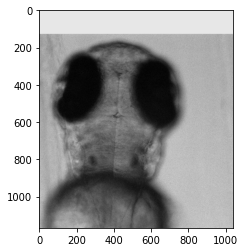

In [53]:
# size of the image stack

# take only one stack 
# print(stackPad.shape)

# test on small dataset
targetStack = stackPad[0,:2,:,:]  # test on two images in one stack
targetStack = np.stack([targetStack], axis=0)
plt.imshow(stackPad[0,0,:,:].squeeze(), cmap='gray')

# test on whole stack of images
# targetStack = stackPad

print(targetStack.shape, targetStack.min(), targetStack.max())

In [54]:
# calculate the stack in metrics

# scan the images in step size
for stackNum in range(targetStack.shape[0]):
    
    for sliceNum in range(targetStack.shape[1]):
        image = np.stack((targetStack[stackNum,sliceNum,...],)*3, axis=-1) 
        for (x, y, window) in slidingStackMetrics(stackNum, sliceNum, image, stepArray=stepArray, windowSize=(winW, winH), savedPath=savedPath, metric = metric):
        # if the window does not meet our desired window size, ignore it
            if window.shape[0] != winH or window.shape[1] != winW:
                continue 

save sucessfully 0
save sucessfully 1


### visualize the feature map

In [5]:
# define the read in function for max projection

def readNpy(data_path):
    fStack = []
    for img in glob.glob(os.path.join(data_path, "*.npy")):
        im = np.load(os.path.join(data_path, img))  
        imarray = np.array(im)
        fStack.append(imarray)  # images, num of slices, channels, img.x, img.y
    return np.asarray(fStack)

In [6]:
def readStack(loadPath, metric):
    
    tempPath = loadPath + str(metric)
    # print(tempPath)
    
    fStacks = []
    for i in range(1):  # one stack
    
        fStackTemp = readNpy(tempPath + '/' + str(i) + '/')
        # print(fStackTemp.shape)
        fStacks.append(fStackTemp)
    
    fStacks = np.asarray(fStacks)
    # print(metric, fStacks.min(), fStacks.max() )
    
    return fStacks

In [61]:
# print(metric, fStacks.shape, fStacks.min(), fStacks.max())
n_stack = 0
# n_slice = random.randint(0, fStacks.shape[1]-1)
n_slice = 0

loadPath = 'E:/LM/LM/digitalConfocal/notebooks/fMax/testResult/contourDetect/'
# metric = 'canny'
metricList = ['canny', 'entropy', 'laplacian', 'prewitt', 'robert', 'sobel', 'std', 'loG']  # loG is slow

canny 0


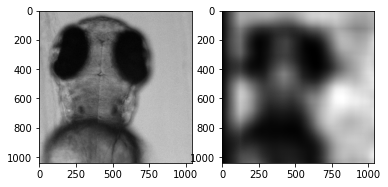

entropy 0


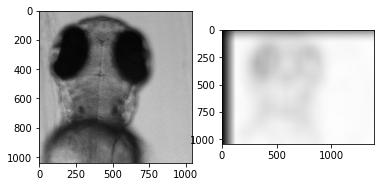

laplacian 0


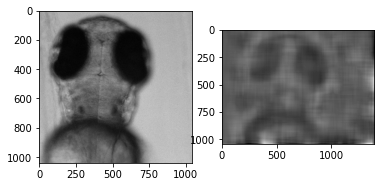

prewitt 0


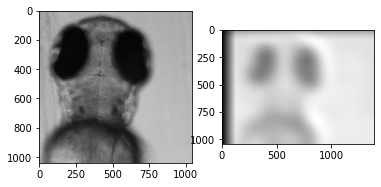

robert 0


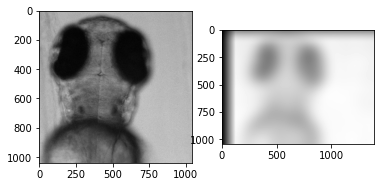

sobel 0


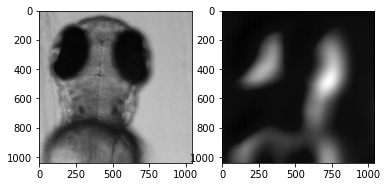

std 0


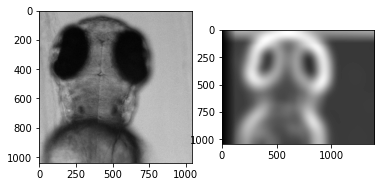

loG 0


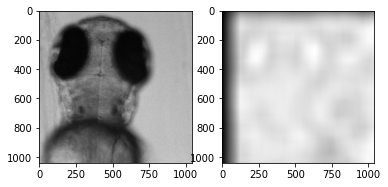

In [62]:
# load all image

allFeature = []

for NUM in range(len(metricList)):
    metric = metricList[NUM]
    tempStack = readStack(loadPath, metric)
    
    print(metric, n_slice)
    subShow(rescaleGray[n_stack,n_slice,:,:], tempStack[n_stack,n_slice,:,:])
    
    allFeature.append(tempStack)
    

### use the image quality inspector to evaluate the patch quality

#### fetch patch

In [7]:
# fetch the patch
# take a patch from two neighbour images

n_stack = 0
# n_slice = random.randint(0, stackPad.shape[1]-1)
n_slice = 1
windowSize = [winW, winH]
print('windows size:', winW)

tempIMG1 = stackPad[n_stack, n_slice, :, :]
tempIMG2 = stackPad[n_stack, n_slice+2, :, :]

# startPoint1 = [0, 0]
# startPoint2 = [250, 250]

startPoint1 = [250, 250]
startPoint2 = startPoint1

# two patches for comparing
tempPatch1 = tempIMG1[startPoint1[0]:startPoint1[0] + windowSize[1], startPoint1[1]:startPoint1[1] + windowSize[0]]
tempPatch2 = tempIMG2[startPoint2[0]:startPoint2[0] + windowSize[1], startPoint2[1]:startPoint2[1] + windowSize[0]]

print('patch max:', tempPatch1.max())

subShow(tempPatch1, tempPatch2)

NameError: name 'winW' is not defined

In [31]:
# various blur detectors

import numpy as np
from skimage import filters
import os
import cv2

# brenner detector
def brenner(img):

    imgMat = img/255.0
    
    x, y = imgMat.shape
    score = 0
    for i in range(x - 2):
        for j in range(y - 2):
            score += (imgMat[i + 2, j] - imgMat[i, j]) ** 2

    score=score/10

    return score

# tenengrad detector
def Tenengrad(img):

    f = img
    tmp = filters.sobel(f)
    source=np.sum(tmp**2)
    source=np.sqrt(source)

    return source

# laplacian
def  laplacian(img):

    resLap = cv2.Laplacian(img, cv2.CV_64F)
    score = resLap.var()
    return score

# SMD
def SMD(img):

    f=img / 255.0 # [0,1]
    x, y = f.shape
    score = 0
    for i in range(x - 1):
        for j in range(y - 1):
            score += np.abs(f[i+1,j]-f[i,j])+np.abs(f[i,j]-f[i+1,j])
    score=score/100
    return score

# SMD2
def SMD2(img):

    f = img/255.0
    x, y = f.shape
    score = 0
    for i in range(x - 1):
        for j in range(y - 1):
            score += np.abs(f[i+1,j]-f[i,j])*np.abs(f[i,j]-f[i,j+1])

    return score

# Variance
def Variance(img):

    f = img
    score = np.var(f)
    return score

# Vollath
def Vollath(img):

    f = img
    source=0
    x,y=f.shape
    for i in range(x-1):
        for j in range(y):
            source+=f[i,j]*f[i+1,j]
    source=source-x*y*np.mean(f)
    
    return source

In [32]:

# brenner
brenner1 = brenner(tempPatch1)
brenner2 = brenner(tempPatch2)
print('brenner:', brenner1, brenner2)

# tenengrad
tenengrad1 = Tenengrad(tempPatch1)
tenengrad2 = Tenengrad(tempPatch2)
print('tenengrad:', tenengrad1, tenengrad2)

# Laplacian
laplacian1 = laplacian(tempPatch1)
laplacian2 = laplacian(tempPatch2)
print('laplacian:', laplacian1, laplacian2)

# SMD
SMD_1 = SMD(tempPatch1)
SMD_2 = SMD(tempPatch2)
print('SMD:', SMD_1, SMD_2)

# SMD2
SMD2_1 = SMD2(tempPatch1)
SMD2_2 = SMD2(tempPatch2)
print('SMD2:', SMD2_1, SMD2_2)

# Variance
Variance1 = Variance(tempPatch1)
Variance2 = Variance(tempPatch2)
print('Variance:', Variance1, Variance2)

# Vollath
Vollath1 = Vollath(tempPatch1)
Vollath2 = Vollath(tempPatch2)
print('Vollath:', Vollath1, Vollath2)

# std
std1 = np.std(tempPatch1)
std2 = np.std(tempPatch2)
print('std:', std1, std2)

brenner: 1.2971918492885866 1.7448735101883126
tenengrad: 2.4141567127265082 2.916695172047226
laplacian: 472.3157033920288 585.4914846420288
SMD: 6.733254901960597 7.550823529411666
SMD2: 8.270157631680286 10.519461745482554
Variance: 761.6104936003685 1405.5896608680487
Vollath: 808590.0 760623.0
std: 27.5972914178252 37.49119444440319


D:\INSTALL\Anaconda\envs\LM\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: overflow encountered in ubyte_scalars


### image quality inspector for whole image

In [13]:
# create the folder to save the stacks

import os

def mkdir(path):
    folder = os.path.exists(path)
    if not folder:                   
        os.makedirs(path)           
    # else:
    #     print('path existed')
    

In [28]:
# various blur detectors
# input patch-uint8

import numpy as np
from skimage import filters
import os
import cv2

# brenner detector
def brenner(img):
    
    imgMat = img/255.0
    
    x, y = imgMat.shape
    score = 0
    for i in range(x - 2):
        for j in range(y - 2):
            score += (imgMat[i + 2, j] - imgMat[i, j]) ** 2

    score = score/10

    return score

# tenengrad detector
def Tenengrad(img):

    f = img
    tmp = filters.sobel(f)
    source = np.sum(tmp**2)
    source = np.sqrt(source)

    return source

# laplacian
def laplacian(img):

    resLap = cv2.Laplacian(img, cv2.CV_64F)
    score = resLap.var()
    score = score/100 # control the range
    return score

# SMD
def SMD(img):

    f=img / 255.0 # [0,1]
    x, y = f.shape
    score = 0
    for i in range(x - 1):
        for j in range(y - 1):
            score += np.abs(f[i+1,j]-f[i,j])+np.abs(f[i,j]-f[i+1,j])
    score=score/100
    return score

# SMD2
def SMD2(img):

    f = img/255.0
    x, y = f.shape
    score = 0
    for i in range(x - 1):
        for j in range(y - 1):
            score += np.abs(f[i+1,j]-f[i,j])*np.abs(f[i,j]-f[i,j+1])

    return score

# Variance
def Variance(img):

    f = img
    score = np.var(f)/1000
    
    return score

# Vollath
def Vollath(img):

    f = img
    source = 0
    x,y = f.shape
    for i in range(x-1):
        for j in range(y):
            source += f[i,j]*f[i+1,j]
    source = source - x*y*np.mean(f)
    source = source/100000
    return source

# rescale the image for comparing
def rescaleIMG(img, MIN, MAX):
    temp = np.interp(img, (img.min(), img.max()), (MIN, MAX))
    return temp

In [15]:
# multiple scans for one image.
# input: stack num, slice num, image, step, windowsize, metric: indicate the metric for detecting

import numpy as np
from skimage import filters
import os
import cv2

# one image
def slidingStackQuality(stackNum, sliceNum, image, stepArray, windowSize, savedPath, metric):
    
    focalStack = []
    
    for i in range(len(stepArray)):
        
        stepSize = stepArray[i]
        # slide a window across the image
        feaMap = np.zeros((image.shape[:2]))  # careful the image is 3 channels

        for y in range(0, image.shape[0], stepSize):
            for x in range(0, image.shape[1], stepSize):
                # yield the current window
                yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
                
                tPatch = image[y:y + windowSize[1], x:x + windowSize[0], 0]  # taking only 1 channel from 3
                
                #########
                if metric == 'std':
                    # Roy. calculate the std
                    tempPatch = np.ones((tPatch.shape)) * np.std((tPatch))
                    
                elif metric == 'brenner':
                    # print('cal robert', tPatch.shape, tPatch.min(), tPatch.max())
                    tempPatch = np.ones((tPatch.shape)) * np.round(brenner(tPatch), 2)
                    # print('robert mean:',tempPatch.mean())
                    
                elif metric == 'laplacian':
                    tempPatch = np.ones((tPatch.shape)) * np.round(laplacian(tPatch), 2)
                    
                elif metric == 'tenengrad':
                    tempPatch = np.ones((tPatch.shape)) * np.round(Tenengrad(tPatch), 2)
                    # print('raw tenengrad:', np.unique(tempPatch))
                    
                elif metric == 'SMD':
                    tempPatch = np.ones((tPatch.shape)) * np.round(SMD(tPatch), 2)
                    
                elif metric == 'SMD2':
                    tempPatch = np.ones((tPatch.shape)) * np.round(SMD2(tPatch), 2)
                    
                elif metric == 'Variance':
                    tempPatch = np.ones((tPatch.shape)) * np.round(Variance(tPatch), 2)
                    
                    
                elif metric == 'Vollath':
                    tempPatch = np.ones((tPatch.shape)) * np.round(Vollath(tPatch), 2)
                
                #########
                feaMap[y:y + windowSize[1], x:x + windowSize[0]] = tempPatch + feaMap[y:y + windowSize[1], x:x + windowSize[0]]
                # print('feature map:', feaMap.min(), feaMap.max())
                
                # temp = feaMap[y:y + windowSize[1], x:x + windowSize[0]]
                # print('patch in img:',temp.min(), temp.max())
                # print('whole img:', feaMap.min(), feaMap.max())
                
                # print(tempStd)
                
#         focalStack.append(stdMap)
        
        focalStack.append(feaMap[padH:, padW:])  # crop the feature map back 
                           
    fMax = np.max(np.asarray(focalStack), axis=0)
    fMax = rescaleIMG(fMax, 0, 255)
                           
#     # rescale before the max projection // otherwise that could be possibel the value is negative
#     fMax = rescaleIMG(np.asarray(focalStack), 0, 255)
    
#     # calculate the stack and conduct max projection
#     fMax = np.max(fMax, axis=0)
    
    # check the saving path
    tempPath = savedPath + '/' + str(stackNum)
    mkdir(tempPath)
    
    # save the max projection in sliceNum under the path 'stackNum'
    np.save(tempPath+'/'+str(sliceNum)+'.npy', fMax)
    print('save sucessfully', sliceNum, tempPath)

In [38]:
# prepare data and path

# step size
# stepArray = [8, 10]
stepArray = [8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36]

# window size
(winW, winH) = (64*2, 64*2)
# (winW, winH) = (512, 512)
# (padW, padH) = (256, 256)

# pad parameters
(padW, padH) = (0, winH)
# (padW, padH) = (0, winH)

# saved path
# savedPath = 'H:/My Drive/rawData/HZDR/LM/fMax_zebrafish/testPadMax'  # google drive
# metricList = ['std', 'brenner', 'tenengrad', 'laplacian', 'SMD', 'SMD2', 'Variance', 'Vollath']  # brenner, SMD, SMD2, Vollath is slow
metric = 'Variance'
savedPath = 'E:/LM/LM/digitalConfocal/notebooks/fMax/testResult/qualityDetect/' + str(metric)
# savedPath = 'E:/LM/LM/digitalConfocal/notebooks/fMax/testResult/' + 'loGtest'
mkdir(savedPath)

In [34]:
# raw data prepare

# print(stackPad.shape)

# test on small dataset
targetStack = stackPad[0,:2,:,:]  # test on two images in one stack
targetStack = np.stack([targetStack], axis=0)
# plt.imshow(stackPad[0,0,:,:].squeeze(), cmap='gray')

# test on whole stack of images
# targetStack = stackPad

print(targetStack.shape, targetStack.min(), targetStack.max())

(1, 2, 1168, 1040) 0 171


In [39]:
# calculate the stack in metrics

for stackNum in range(targetStack.shape[0]):
    
    for sliceNum in range(targetStack.shape[1]):
        image = np.stack((targetStack[stackNum,sliceNum,...],)*3, axis=-1) 
        for (x, y, window) in slidingStackQuality(stackNum, sliceNum, image, stepArray=stepArray, windowSize=(winW, winH), savedPath=savedPath, metric = metric):
        # if the window does not meet our desired window size, ignore it
            if window.shape[0] != winH or window.shape[1] != winW:
                continue 

save sucessfully 0 E:/LM/LM/digitalConfocal/notebooks/fMax/testResult/qualityDetect/Variance/0
save sucessfully 1 E:/LM/LM/digitalConfocal/notebooks/fMax/testResult/qualityDetect/Variance/0


#### visualize the quality detector result

In [40]:
# define the read in function for max projection

def readNpy(data_path):
    fStack = []
    for img in glob.glob(os.path.join(data_path, "*.npy")):
        im = np.load(os.path.join(data_path, img))  
        imarray = np.array(im)
        fStack.append(imarray)  # images, num of slices, channels, img.x, img.y
    return np.asarray(fStack)

In [41]:
def readStack(loadPath, metric):
    
    tempPath = loadPath + str(metric)
    print(tempPath)
    
    fStacks = []
    for i in range(1):  # one stack
    
        fStackTemp = readNpy(tempPath + '/' + str(i) + '/')
        # print(fStackTemp.shape)
        fStacks.append(fStackTemp)
    
    fStacks = np.asarray(fStacks)
    # print(metric, fStacks.min(), fStacks.max() )
    
    return fStacks

In [42]:
# print(metric, fStacks.shape, fStacks.min(), fStacks.max())
n_stack = 0
# n_slice = random.randint(0, fStacks.shape[1]-1)
n_slice = 1

loadPath = 'E:/LM/LM/digitalConfocal/notebooks/fMax/testResult/qualityDetect/'
# metric = 'canny'
# metricList = ['std', 'brenner', 'tenengrad', 'laplacian', 'SMD', 'SMD2', 'Variance', 'Vollath']
metricList = ['std', 'brenner', 'tenengrad', 'laplacian', 'Variance']
# metricList = ['std']
print(savedPath)

E:/LM/LM/digitalConfocal/notebooks/fMax/testResult/qualityDetect/Variance


E:/LM/LM/digitalConfocal/notebooks/fMax/testResult/qualityDetect/Variance
(1040, 1040) 0.0 255.0


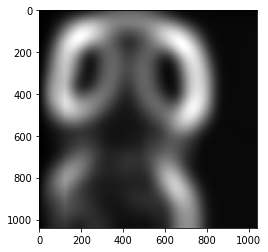

In [43]:
#测试单张

print(savedPath)

test = np.load(savedPath + '/0/1.npy')

print(test.shape, test.min(), test.max())

plt.imshow(test, cmap='gray')

E:/LM/LM/digitalConfocal/notebooks/fMax/testResult/qualityDetect/std
(1, 2, 1040, 1040)
std 1


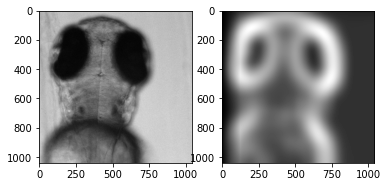

E:/LM/LM/digitalConfocal/notebooks/fMax/testResult/qualityDetect/brenner
(1, 2, 1040, 1392)
brenner 1


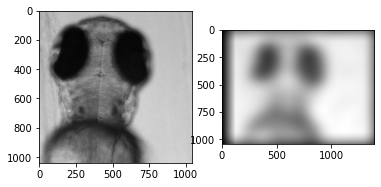

E:/LM/LM/digitalConfocal/notebooks/fMax/testResult/qualityDetect/tenengrad
(1, 2, 1040, 1040)
tenengrad 1


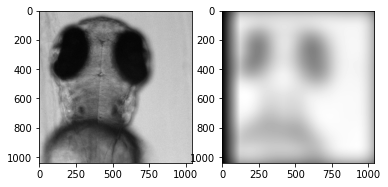

E:/LM/LM/digitalConfocal/notebooks/fMax/testResult/qualityDetect/laplacian
(1, 2, 1040, 1040)
laplacian 1


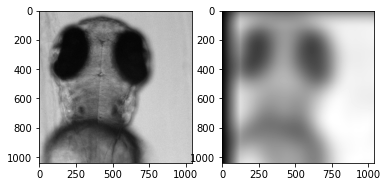

E:/LM/LM/digitalConfocal/notebooks/fMax/testResult/qualityDetect/Variance
(1, 2, 1040, 1040)
Variance 1


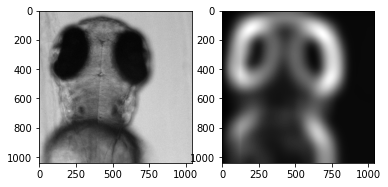

In [44]:
# load all image

allFeature = []

for NUM in range(len(metricList)):
    metric = metricList[NUM]
    tempStack = readStack(loadPath, metric)  # change into correct path
    print(tempStack.shape)
    
    print(metric, n_slice)
    subShow(rescaleGray[n_stack,n_slice,:,:], tempStack[n_stack,n_slice,:,:])
    
    allFeature.append(tempStack)

### calculate the mask